In [1]:
!pip install featuretools==0.19.0

In [2]:
import featuretools as ft
import pandas as pd
import numpy as np
import sqlite3


In [3]:
database = '/content/sample_data/database.sqlite'
conn = sqlite3.connect(database)

In [4]:
matches_df = pd.read_sql("""SELECT * from MATCH""", conn)
teams_df = pd.read_sql("""SELECT * from TEAM""", conn)
player_attributes_df = pd.read_sql("""SELECT * from PLAYER_ATTRIBUTES""", conn)

matches_df['date'] = pd.to_datetime(matches_df['date'], format='%Y-%m-%d 00:00:00')

In [5]:
home_players = ["home_player_" + str(x) for x in range(1, 12)]
away_players = ["away_player_" + str(x) for x in range(1, 12)]

betting_columns = ["B365H", "B365D", "B365A"]

matches_kept_columns = ["id", "date", "home_team_api_id", "away_team_api_id", "home_team_goal", "away_team_goal"]
matches_kept_columns = matches_kept_columns + home_players
matches_kept_columns = matches_kept_columns + away_players
matches_kept_columns = matches_kept_columns + betting_columns

matches_df = matches_df[matches_kept_columns]

In [6]:
matches_df['goal_difference'] = matches_df['home_team_goal'] - matches_df['away_team_goal']
matches_df['home_status'] = 'D'
matches_df['home_status'] = np.where(matches_df['goal_difference'] > 0, 'W', matches_df['home_status'])
matches_df['home_status'] = np.where(matches_df['goal_difference'] < 0, 'L', matches_df['home_status'])

for player in home_players:
    matches_df = pd.merge(matches_df, player_attributes_df[["id", "overall_rating"]], left_on=[player], right_on=["id"], suffixes=["", "_" + player])
for player in away_players:
    matches_df = pd.merge(matches_df, player_attributes_df[["id", "overall_rating"]], left_on=[player], right_on=["id"], suffixes=["", "_" + player])

matches_df = matches_df.rename(columns={"overall_rating": "overall_rating_home_player_1"})

matches_df = matches_df[ matches_df[['overall_rating_' + p for p in home_players]].isnull().sum(axis = 1) <= 0]
matches_df = matches_df[ matches_df[['overall_rating_' + p for p in away_players]].isnull().sum(axis = 1) <= 0]

matches_df['overall_rating_home'] = matches_df[['overall_rating_' + p for p in home_players]].sum(axis=1)
matches_df['overall_rating_away'] = matches_df[['overall_rating_' + p for p in away_players]].sum(axis=1)
matches_df['overall_rating_difference'] = matches_df['overall_rating_home'] - matches_df['overall_rating_away']

matches_df['min_overall_rating_home'] = matches_df[['overall_rating_' + p for p in home_players]].min(axis=1)
matches_df['min_overall_rating_away'] = matches_df[['overall_rating_' + p for p in away_players]].min(axis=1)

matches_df['max_overall_rating_home'] = matches_df[['overall_rating_' + p for p in home_players]].max(axis=1)
matches_df['max_overall_rating_away'] = matches_df[['overall_rating_' + p for p in away_players]].max(axis=1)

matches_df['mean_overall_rating_home'] = matches_df[['overall_rating_' + p for p in home_players]].mean(axis=1)
matches_df['mean_overall_rating_away'] = matches_df[['overall_rating_' + p for p in away_players]].mean(axis=1)

matches_df['std_overall_rating_home'] = matches_df[['overall_rating_' + p for p in home_players]].std(axis=1)
matches_df['std_overall_rating_away'] = matches_df[['overall_rating_' + p for p in away_players]].std(axis=1)

In [7]:
for c in matches_df.columns:
    if '_player_' in c:
        matches_df = matches_df.drop(c, axis=1)

In [8]:
ct_home_matches = pd.DataFrame()
ct_away_matches = pd.DataFrame()

ct_matches = pd.DataFrame()

# Trick to exclude current match from statistics and do not biais predictions
ct_home_matches['time'] = matches_df['date'] - pd.Timedelta(hours=1)
ct_home_matches['instance_id'] = matches_df['home_team_api_id']
ct_home_matches['label'] = (ct_home_matches['instance_id'] == ct_home_matches['instance_id'])

# Trick to exclude current match from statistics and do not biais predictions
ct_away_matches['time'] = matches_df['date'] - pd.Timedelta(hours=1)
ct_away_matches['instance_id'] = matches_df['away_team_api_id']
ct_away_matches['label'] = (ct_away_matches['instance_id'] == ct_away_matches['instance_id'])

ct_matches = pd.concat([ct_home_matches, ct_away_matches], ignore_index=True)

In [9]:
es = ft.EntitySet("entityset")

es.entity_from_dataframe(entity_id="home_matches",
                        index="id",
                        time_index="date",
                        dataframe=matches_df,
                        variable_types={"home_team_api_id": ft.variable_types.Categorical,
                                              "away_team_api_id": ft.variable_types.Categorical,
                                              "home_status": ft.variable_types.Categorical,
                                              "home_team_goal":     ft.variable_types.Numeric,
                                              "away_team_goal":     ft.variable_types.Numeric})

es.entity_from_dataframe(entity_id="away_matches",
                        index="id",
                        time_index="date",
                        dataframe=matches_df,
                        variable_types={"home_team_api_id": ft.variable_types.Categorical,
                                              "away_team_api_id": ft.variable_types.Categorical,
                                              "home_status": ft.variable_types.Categorical,
                                              "home_team_goal":     ft.variable_types.Numeric,
                                              "away_team_goal":     ft.variable_types.Numeric})

es.entity_from_dataframe(entity_id="teams",
                         index="team_api_id",
                         dataframe=teams_df)

es.add_last_time_indexes()

new_relationship = ft.Relationship(es["teams"]["team_api_id"],
                                   es["home_matches"]["home_team_api_id"])
es = es.add_relationship(new_relationship)

new_relationship = ft.Relationship(es["teams"]["team_api_id"],
                                   es["away_matches"]["away_team_api_id"])
es = es.add_relationship(new_relationship)

feature_matrix, features_defs = ft.dfs(entities=es,
                                       entityset=es,
                                       cutoff_time=ct_matches,
                                       cutoff_time_in_index=True,
                                       training_window='60 days',
                                       max_depth=3,
                                       target_entity="teams",
                                       verbose=True
                                      )

print(feature_matrix)

/usr/local/lib/python3.10/dist-packages/featuretools/entityset/entityset.py:886: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lti_df = pd.Series()
/usr/local/lib/python3.10/dist-packages/featuretools/entityset/entityset.py:886: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lti_df = pd.Series()
/usr/local/lib/python3.10/dist-packages/featuretools/entityset/entityset.py:886: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lti_df = pd.Series()
/usr/local/lib/python3.10/dist-packages/featuretools/entityset/entityset.py:886: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype

Built 234 features
Elapsed: 00:00 | Progress:   0%|          

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This i

Elapsed: 00:00 | Progress:   0%|          

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This i

Elapsed: 00:00 | Progress:   0%|          

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:01 | Progress:   0%|          

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:01 | Progress:   1%|          

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:02 | Progress:   1%|          

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:02 | Progress:   1%|          

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:03 | Progress:   1%|          

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:03 | Progress:   1%|          

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:05 | Progress:   1%|          

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:05 | Progress:   1%|          

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:06 | Progress:   1%|          

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:07 | Progress:   1%|▏         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:07 | Progress:   1%|▏         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:08 | Progress:   2%|▏         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:08 | Progress:   2%|▏         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:09 | Progress:   2%|▏         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:09 | Progress:   2%|▏         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:10 | Progress:   2%|▏         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:10 | Progress:   2%|▏         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:11 | Progress:   2%|▏         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:11 | Progress:   2%|▏         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:12 | Progress:   3%|▎         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:12 | Progress:   3%|▎         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:13 | Progress:   3%|▎         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 00:15 | Progress:   3%|▎         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:15 | Progress:   3%|▎         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:16 | Progress:   3%|▎         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:16 | Progress:   4%|▎         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:17 | Progress:   4%|▎         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:18 | Progress:   4%|▍         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:19 | Progress:   4%|▍         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:20 | Progress:   4%|▍         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:20 | Progress:   4%|▍         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:21 | Progress:   5%|▍         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:21 | Progress:   5%|▍         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:21 | Progress:   5%|▍         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 00:22 | Progress:   5%|▍         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:22 | Progress:   5%|▌         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:22 | Progress:   5%|▌         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:23 | Progress:   5%|▌         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:23 | Progress:   5%|▌         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:23 | Progress:   6%|▌         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:23 | Progress:   6%|▌         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:24 | Progress:   6%|▌         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:24 | Progress:   6%|▌         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:24 | Progress:   6%|▌         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:25 | Progress:   6%|▋         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:25 | Progress:   6%|▋         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:25 | Progress:   7%|▋         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 00:26 | Progress:   7%|▋         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:26 | Progress:   7%|▋         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:26 | Progress:   7%|▋         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:27 | Progress:   7%|▋         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 00:27 | Progress:   7%|▋         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:28 | Progress:   8%|▊         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:28 | Progress:   8%|▊         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:28 | Progress:   8%|▊         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:29 | Progress:   8%|▊         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:29 | Progress:   8%|▊         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:29 | Progress:   9%|▊         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 00:30 | Progress:   9%|▊         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:30 | Progress:   9%|▉         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:30 | Progress:   9%|▉         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:30 | Progress:   9%|▉         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:31 | Progress:   9%|▉         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:31 | Progress:   9%|▉         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:31 | Progress:   9%|▉         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:32 | Progress:  10%|▉         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:32 | Progress:  10%|▉         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 00:33 | Progress:  10%|▉         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:33 | Progress:  10%|█         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:34 | Progress:  10%|█         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:34 | Progress:  10%|█         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:34 | Progress:  10%|█         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:35 | Progress:  10%|█         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:35 | Progress:  11%|█         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:36 | Progress:  11%|█         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:36 | Progress:  11%|█         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:36 | Progress:  11%|█         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:36 | Progress:  11%|█         

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:37 | Progress:  11%|█▏        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:37 | Progress:  11%|█▏        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 00:38 | Progress:  12%|█▏        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:38 | Progress:  12%|█▏        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:38 | Progress:  12%|█▏        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:39 | Progress:  12%|█▏        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:39 | Progress:  12%|█▏        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:39 | Progress:  12%|█▏        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 00:40 | Progress:  12%|█▏        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:40 | Progress:  12%|█▏        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:40 | Progress:  12%|█▏        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:40 | Progress:  13%|█▎        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:41 | Progress:  13%|█▎        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:41 | Progress:  13%|█▎        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:41 | Progress:  13%|█▎        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:42 | Progress:  13%|█▎        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:42 | Progress:  13%|█▎        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:42 | Progress:  13%|█▎        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:43 | Progress:  14%|█▎        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:43 | Progress:  14%|█▍        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:43 | Progress:  14%|█▍        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:44 | Progress:  14%|█▍        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:44 | Progress:  14%|█▍        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:44 | Progress:  14%|█▍        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:44 | Progress:  14%|█▍        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:45 | Progress:  15%|█▍        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:45 | Progress:  15%|█▍        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:45 | Progress:  15%|█▍        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:45 | Progress:  15%|█▌        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 00:46 | Progress:  15%|█▌        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:46 | Progress:  15%|█▌        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This i

Elapsed: 00:47 | Progress:  15%|█▌        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:47 | Progress:  16%|█▌        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:48 | Progress:  16%|█▌        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:48 | Progress:  16%|█▌        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:48 | Progress:  16%|█▌        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This i

Elapsed: 00:49 | Progress:  16%|█▌        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:49 | Progress:  16%|█▌        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:50 | Progress:  16%|█▋        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:50 | Progress:  17%|█▋        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:51 | Progress:  17%|█▋        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:51 | Progress:  17%|█▋        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:51 | Progress:  17%|█▋        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:52 | Progress:  17%|█▋        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:52 | Progress:  17%|█▋        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:52 | Progress:  17%|█▋        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:53 | Progress:  17%|█▋        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:53 | Progress:  18%|█▊        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:53 | Progress:  18%|█▊        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:54 | Progress:  18%|█▊        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:54 | Progress:  18%|█▊        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 00:55 | Progress:  18%|█▊        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:55 | Progress:  18%|█▊        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:55 | Progress:  19%|█▊        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:56 | Progress:  19%|█▉        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

Elapsed: 00:56 | Progress:  19%|█▉        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This i

Elapsed: 00:56 | Progress:  19%|█▉        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:57 | Progress:  19%|█▉        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:57 | Progress:  19%|█▉        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:57 | Progress:  20%|█▉        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 00:58 | Progress:  20%|█▉        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:59 | Progress:  20%|█▉        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:59 | Progress:  20%|██        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 00:59 | Progress:  20%|██        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:00 | Progress:  20%|██        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:00 | Progress:  20%|██        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:00 | Progress:  21%|██        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:01 | Progress:  21%|██        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:01 | Progress:  21%|██        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:01 | Progress:  21%|██        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:02 | Progress:  21%|██        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:03 | Progress:  21%|██        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:03 | Progress:  21%|██        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:03 | Progress:  21%|██        

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:03 | Progress:  21%|██▏       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:04 | Progress:  21%|██▏       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:04 | Progress:  22%|██▏       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:04 | Progress:  22%|██▏       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 01:05 | Progress:  22%|██▏       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:05 | Progress:  22%|██▏       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:05 | Progress:  22%|██▏       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:05 | Progress:  22%|██▏       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:06 | Progress:  23%|██▎       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 01:06 | Progress:  23%|██▎       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:06 | Progress:  23%|██▎       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:07 | Progress:  23%|██▎       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:07 | Progress:  23%|██▎       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:07 | Progress:  23%|██▎       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:07 | Progress:  23%|██▎       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:08 | Progress:  23%|██▎       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:08 | Progress:  24%|██▎       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:08 | Progress:  24%|██▍       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:09 | Progress:  24%|██▍       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:09 | Progress:  24%|██▍       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:09 | Progress:  24%|██▍       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:10 | Progress:  24%|██▍       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:10 | Progress:  25%|██▍       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:10 | Progress:  25%|██▍       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:11 | Progress:  25%|██▌       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:11 | Progress:  25%|██▌       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:11 | Progress:  25%|██▌       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 01:12 | Progress:  25%|██▌       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:12 | Progress:  25%|██▌       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:12 | Progress:  25%|██▌       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:12 | Progress:  25%|██▌       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:13 | Progress:  25%|██▌       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:13 | Progress:  25%|██▌       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:14 | Progress:  25%|██▌       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:14 | Progress:  26%|██▌       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:14 | Progress:  26%|██▌       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:15 | Progress:  26%|██▌       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This i

Elapsed: 01:15 | Progress:  26%|██▌       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:15 | Progress:  26%|██▌       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:16 | Progress:  26%|██▋       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:16 | Progress:  27%|██▋       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:16 | Progress:  27%|██▋       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:16 | Progress:  27%|██▋       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:17 | Progress:  27%|██▋       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:17 | Progress:  27%|██▋       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:17 | Progress:  27%|██▋       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:17 | Progress:  27%|██▋       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:18 | Progress:  27%|██▋       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:18 | Progress:  28%|██▊       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 01:19 | Progress:  28%|██▊       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:19 | Progress:  28%|██▊       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:19 | Progress:  28%|██▊       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:19 | Progress:  28%|██▊       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:20 | Progress:  29%|██▊       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:20 | Progress:  29%|██▊       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:20 | Progress:  29%|██▉       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:21 | Progress:  29%|██▉       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:21 | Progress:  29%|██▉       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:21 | Progress:  30%|██▉       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:21 | Progress:  30%|██▉       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:22 | Progress:  30%|██▉       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:22 | Progress:  30%|███       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:22 | Progress:  30%|███       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:23 | Progress:  30%|███       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:23 | Progress:  30%|███       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:23 | Progress:  31%|███       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:24 | Progress:  31%|███       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:24 | Progress:  31%|███       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:24 | Progress:  31%|███       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:24 | Progress:  31%|███       

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:25 | Progress:  31%|███▏      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:25 | Progress:  32%|███▏      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:25 | Progress:  32%|███▏      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 01:26 | Progress:  32%|███▏      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:26 | Progress:  32%|███▏      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:26 | Progress:  32%|███▏      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:27 | Progress:  32%|███▏      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:27 | Progress:  32%|███▏      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 01:28 | Progress:  33%|███▎      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:29 | Progress:  33%|███▎      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:29 | Progress:  33%|███▎      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:29 | Progress:  33%|███▎      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:30 | Progress:  33%|███▎      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:30 | Progress:  34%|███▎      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:31 | Progress:  34%|███▍      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:31 | Progress:  34%|███▍      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:31 | Progress:  34%|███▍      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:32 | Progress:  34%|███▍      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:32 | Progress:  34%|███▍      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 01:32 | Progress:  35%|███▍      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:33 | Progress:  35%|███▍      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:33 | Progress:  35%|███▌      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:33 | Progress:  35%|███▌      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:34 | Progress:  35%|███▌      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 01:34 | Progress:  35%|███▌      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:35 | Progress:  36%|███▌      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:35 | Progress:  36%|███▌      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:35 | Progress:  36%|███▌      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:36 | Progress:  36%|███▋      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 01:36 | Progress:  36%|███▋      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:36 | Progress:  37%|███▋      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:37 | Progress:  37%|███▋      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:37 | Progress:  37%|███▋      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:37 | Progress:  37%|███▋      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 01:38 | Progress:  37%|███▋      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:38 | Progress:  37%|███▋      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:38 | Progress:  38%|███▊      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:39 | Progress:  38%|███▊      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:39 | Progress:  38%|███▊      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 01:39 | Progress:  38%|███▊      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:40 | Progress:  38%|███▊      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:40 | Progress:  38%|███▊      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:41 | Progress:  39%|███▊      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:41 | Progress:  39%|███▉      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 01:42 | Progress:  39%|███▉      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:42 | Progress:  39%|███▉      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:42 | Progress:  39%|███▉      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:43 | Progress:  39%|███▉      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:43 | Progress:  39%|███▉      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:43 | Progress:  40%|███▉      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:44 | Progress:  40%|███▉      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:44 | Progress:  40%|███▉      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:44 | Progress:  40%|███▉      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:45 | Progress:  40%|███▉      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:45 | Progress:  40%|████      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:45 | Progress:  40%|████      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:45 | Progress:  40%|████      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

Elapsed: 01:46 | Progress:  40%|████      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:46 | Progress:  41%|████      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:46 | Progress:  41%|████      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:47 | Progress:  41%|████      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:47 | Progress:  41%|████      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:47 | Progress:  41%|████      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:48 | Progress:  41%|████      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:48 | Progress:  41%|████      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:48 | Progress:  41%|████      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:48 | Progress:  41%|████      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:49 | Progress:  41%|████      

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:49 | Progress:  41%|████▏     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:49 | Progress:  42%|████▏     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 01:50 | Progress:  42%|████▏     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:50 | Progress:  42%|████▏     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:50 | Progress:  42%|████▏     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:51 | Progress:  42%|████▏     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:51 | Progress:  42%|████▏     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:51 | Progress:  42%|████▏     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:52 | Progress:  42%|████▏     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:52 | Progress:  43%|████▎     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:52 | Progress:  43%|████▎     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:52 | Progress:  43%|████▎     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:53 | Progress:  43%|████▎     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:53 | Progress:  43%|████▎     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:53 | Progress:  43%|████▎     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:54 | Progress:  43%|████▎     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:54 | Progress:  43%|████▎     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:55 | Progress:  44%|████▎     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:55 | Progress:  44%|████▍     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:55 | Progress:  44%|████▍     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:56 | Progress:  44%|████▍     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:56 | Progress:  44%|████▍     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:56 | Progress:  44%|████▍     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:57 | Progress:  44%|████▍     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:58 | Progress:  44%|████▍     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:58 | Progress:  45%|████▍     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:59 | Progress:  45%|████▍     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:59 | Progress:  45%|████▌     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:59 | Progress:  45%|████▌     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 01:59 | Progress:  45%|████▌     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:00 | Progress:  45%|████▌     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:00 | Progress:  45%|████▌     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:00 | Progress:  46%|████▌     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:00 | Progress:  46%|████▌     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:01 | Progress:  46%|████▌     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 02:01 | Progress:  46%|████▌     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:02 | Progress:  46%|████▌     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:02 | Progress:  46%|████▌     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:02 | Progress:  46%|████▋     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:02 | Progress:  47%|████▋     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:03 | Progress:  47%|████▋     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 02:03 | Progress:  47%|████▋     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:04 | Progress:  47%|████▋     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:04 | Progress:  47%|████▋     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:04 | Progress:  48%|████▊     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:05 | Progress:  48%|████▊     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:05 | Progress:  48%|████▊     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:05 | Progress:  48%|████▊     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:05 | Progress:  48%|████▊     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:06 | Progress:  48%|████▊     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 02:06 | Progress:  49%|████▊     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:06 | Progress:  49%|████▊     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:07 | Progress:  49%|████▊     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:07 | Progress:  49%|████▉     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:07 | Progress:  49%|████▉     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:08 | Progress:  49%|████▉     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:08 | Progress:  49%|████▉     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 02:09 | Progress:  49%|████▉     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 02:09 | Progress:  49%|████▉     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:09 | Progress:  50%|████▉     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:10 | Progress:  50%|████▉     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:10 | Progress:  50%|█████     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:11 | Progress:  50%|█████     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:11 | Progress:  50%|█████     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:12 | Progress:  51%|█████     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:12 | Progress:  51%|█████     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:12 | Progress:  51%|█████     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:13 | Progress:  51%|█████     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:13 | Progress:  51%|█████     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:13 | Progress:  51%|█████     

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:13 | Progress:  51%|█████▏    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 02:14 | Progress:  51%|█████▏    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 02:15 | Progress:  51%|█████▏    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:15 | Progress:  52%|█████▏    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:15 | Progress:  52%|█████▏    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:15 | Progress:  52%|█████▏    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:16 | Progress:  52%|█████▏    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:16 | Progress:  52%|█████▏    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:16 | Progress:  52%|█████▏    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:17 | Progress:  52%|█████▏    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:17 | Progress:  53%|█████▎    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:17 | Progress:  53%|█████▎    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:18 | Progress:  53%|█████▎    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:18 | Progress:  53%|█████▎    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:18 | Progress:  53%|█████▎    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 02:19 | Progress:  53%|█████▎    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:19 | Progress:  53%|█████▎    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:19 | Progress:  54%|█████▎    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:20 | Progress:  54%|█████▍    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:20 | Progress:  54%|█████▍    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 02:21 | Progress:  54%|█████▍    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:21 | Progress:  54%|█████▍    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:21 | Progress:  54%|█████▍    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:21 | Progress:  55%|█████▍    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:22 | Progress:  55%|█████▍    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 02:22 | Progress:  55%|█████▍    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:23 | Progress:  55%|█████▍    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:23 | Progress:  55%|█████▌    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:24 | Progress:  55%|█████▌    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:24 | Progress:  55%|█████▌    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:24 | Progress:  55%|█████▌    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:25 | Progress:  56%|█████▌    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:25 | Progress:  56%|█████▌    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:25 | Progress:  56%|█████▌    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:26 | Progress:  56%|█████▌    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:26 | Progress:  56%|█████▌    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:26 | Progress:  56%|█████▋    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 02:27 | Progress:  56%|█████▋    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:27 | Progress:  57%|█████▋    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:27 | Progress:  57%|█████▋    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.

Elapsed: 02:28 | Progress:  57%|█████▋    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This i

Elapsed: 02:28 | Progress:  57%|█████▋    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:28 | Progress:  57%|█████▋    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This i

Elapsed: 02:29 | Progress:  57%|█████▋    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

Elapsed: 02:29 | Progress:  57%|█████▋    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:29 | Progress:  57%|█████▋    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:29 | Progress:  57%|█████▋    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.

Elapsed: 02:30 | Progress:  58%|█████▊    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:30 | Progress:  58%|█████▊    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:31 | Progress:  58%|█████▊    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 02:31 | Progress:  58%|█████▊    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:31 | Progress:  58%|█████▊    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:32 | Progress:  59%|█████▊    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.

Elapsed: 02:32 | Progress:  59%|█████▊    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:33 | Progress:  59%|█████▉    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:33 | Progress:  59%|█████▉    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:33 | Progress:  59%|█████▉    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 02:34 | Progress:  59%|█████▉    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:34 | Progress:  60%|█████▉    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:34 | Progress:  60%|█████▉    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:35 | Progress:  60%|█████▉    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 02:35 | Progress:  60%|██████    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:35 | Progress:  60%|██████    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:36 | Progress:  60%|██████    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:36 | Progress:  60%|██████    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:36 | Progress:  61%|██████    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:37 | Progress:  61%|██████    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:37 | Progress:  61%|██████    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:37 | Progress:  61%|██████    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:38 | Progress:  61%|██████    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:38 | Progress:  61%|██████    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:38 | Progress:  61%|██████    

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:39 | Progress:  61%|██████▏   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:39 | Progress:  62%|██████▏   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:40 | Progress:  62%|██████▏   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:40 | Progress:  62%|██████▏   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:40 | Progress:  62%|██████▏   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:40 | Progress:  62%|██████▏   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:41 | Progress:  62%|██████▏   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:41 | Progress:  62%|██████▏   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:41 | Progress:  62%|██████▏   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:41 | Progress:  63%|██████▎   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:42 | Progress:  63%|██████▎   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:42 | Progress:  63%|██████▎   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:42 | Progress:  63%|██████▎   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:42 | Progress:  63%|██████▎   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:43 | Progress:  63%|██████▎   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:43 | Progress:  63%|██████▎   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:43 | Progress:  63%|██████▎   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:44 | Progress:  64%|██████▎   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:44 | Progress:  64%|██████▍   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:44 | Progress:  64%|██████▍   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:44 | Progress:  64%|██████▍   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:45 | Progress:  64%|██████▍   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:45 | Progress:  64%|██████▍   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 02:46 | Progress:  65%|██████▍   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:46 | Progress:  65%|██████▍   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 02:46 | Progress:  65%|██████▍   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:47 | Progress:  65%|██████▍   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:47 | Progress:  65%|██████▌   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:47 | Progress:  65%|██████▌   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:47 | Progress:  65%|██████▌   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:48 | Progress:  65%|██████▌   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:48 | Progress:  66%|██████▌   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:48 | Progress:  66%|██████▌   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:49 | Progress:  66%|██████▌   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:49 | Progress:  66%|██████▌   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:50 | Progress:  66%|██████▌   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:50 | Progress:  66%|██████▌   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:50 | Progress:  66%|██████▋   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:50 | Progress:  66%|██████▋   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:51 | Progress:  66%|██████▋   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:51 | Progress:  66%|██████▋   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:51 | Progress:  67%|██████▋   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:52 | Progress:  67%|██████▋   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:52 | Progress:  67%|██████▋   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:52 | Progress:  67%|██████▋   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

Elapsed: 02:53 | Progress:  67%|██████▋   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:53 | Progress:  67%|██████▋   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:54 | Progress:  67%|██████▋   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:54 | Progress:  67%|██████▋   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:54 | Progress:  67%|██████▋   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 02:55 | Progress:  67%|██████▋   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:55 | Progress:  67%|██████▋   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:55 | Progress:  68%|██████▊   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:56 | Progress:  68%|██████▊   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:57 | Progress:  68%|██████▊   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 02:58 | Progress:  68%|██████▊   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:58 | Progress:  68%|██████▊   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:58 | Progress:  68%|██████▊   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:58 | Progress:  68%|██████▊   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:59 | Progress:  68%|██████▊   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:59 | Progress:  68%|██████▊   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 02:59 | Progress:  68%|██████▊   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 03:00 | Progress:  68%|██████▊   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:00 | Progress:  68%|██████▊   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:00 | Progress:  68%|██████▊   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:01 | Progress:  69%|██████▊   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:01 | Progress:  69%|██████▊   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:01 | Progress:  69%|██████▊   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:02 | Progress:  69%|██████▉   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:02 | Progress:  69%|██████▉   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:02 | Progress:  69%|██████▉   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:02 | Progress:  69%|██████▉   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:02 | Progress:  69%|██████▉   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:03 | Progress:  69%|██████▉   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:03 | Progress:  69%|██████▉   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

Elapsed: 03:03 | Progress:  69%|██████▉   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:04 | Progress:  69%|██████▉   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:04 | Progress:  70%|██████▉   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:04 | Progress:  70%|██████▉   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 03:05 | Progress:  70%|██████▉   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 03:06 | Progress:  70%|██████▉   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:06 | Progress:  70%|███████   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:06 | Progress:  70%|███████   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:07 | Progress:  70%|███████   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:07 | Progress:  70%|███████   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:08 | Progress:  70%|███████   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 03:08 | Progress:  70%|███████   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:09 | Progress:  71%|███████   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:09 | Progress:  71%|███████   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:09 | Progress:  71%|███████   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:10 | Progress:  71%|███████   

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:10 | Progress:  71%|███████▏  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:10 | Progress:  72%|███████▏  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 03:11 | Progress:  72%|███████▏  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:11 | Progress:  72%|███████▏  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:11 | Progress:  72%|███████▏  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:12 | Progress:  72%|███████▏  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 03:12 | Progress:  72%|███████▏  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:13 | Progress:  72%|███████▏  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:13 | Progress:  72%|███████▏  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:13 | Progress:  72%|███████▏  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:13 | Progress:  73%|███████▎  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 03:14 | Progress:  73%|███████▎  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:14 | Progress:  73%|███████▎  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 03:15 | Progress:  73%|███████▎  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:15 | Progress:  73%|███████▎  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:15 | Progress:  73%|███████▎  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:15 | Progress:  73%|███████▎  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:16 | Progress:  73%|███████▎  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 03:16 | Progress:  74%|███████▎  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:17 | Progress:  74%|███████▎  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:17 | Progress:  74%|███████▍  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:17 | Progress:  74%|███████▍  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 03:18 | Progress:  74%|███████▍  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:19 | Progress:  74%|███████▍  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:19 | Progress:  74%|███████▍  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:19 | Progress:  75%|███████▍  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:20 | Progress:  75%|███████▍  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:20 | Progress:  75%|███████▍  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:20 | Progress:  75%|███████▍  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:21 | Progress:  75%|███████▌  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:21 | Progress:  75%|███████▌  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 03:22 | Progress:  75%|███████▌  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:22 | Progress:  75%|███████▌  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:22 | Progress:  75%|███████▌  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:23 | Progress:  76%|███████▌  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 03:23 | Progress:  76%|███████▌  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:23 | Progress:  76%|███████▌  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:24 | Progress:  76%|███████▌  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 03:24 | Progress:  76%|███████▌  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:25 | Progress:  76%|███████▌  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:25 | Progress:  76%|███████▋  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:25 | Progress:  76%|███████▋  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:26 | Progress:  77%|███████▋  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:26 | Progress:  77%|███████▋  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:26 | Progress:  77%|███████▋  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:27 | Progress:  77%|███████▋  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:27 | Progress:  77%|███████▋  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:27 | Progress:  77%|███████▋  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:28 | Progress:  77%|███████▋  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:28 | Progress:  77%|███████▋  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:28 | Progress:  77%|███████▋  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:29 | Progress:  77%|███████▋  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:29 | Progress:  78%|███████▊  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:29 | Progress:  78%|███████▊  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:30 | Progress:  78%|███████▊  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:30 | Progress:  78%|███████▊  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 03:30 | Progress:  78%|███████▊  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:31 | Progress:  78%|███████▊  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:31 | Progress:  78%|███████▊  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:31 | Progress:  78%|███████▊  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 03:32 | Progress:  78%|███████▊  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:32 | Progress:  78%|███████▊  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This i

Elapsed: 03:32 | Progress:  78%|███████▊  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This i

Elapsed: 03:33 | Progress:  78%|███████▊  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This i

Elapsed: 03:33 | Progress:  78%|███████▊  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This i

Elapsed: 03:33 | Progress:  78%|███████▊  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This i

Elapsed: 03:34 | Progress:  79%|███████▊  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

Elapsed: 03:34 | Progress:  79%|███████▊  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:34 | Progress:  79%|███████▉  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This i

Elapsed: 03:35 | Progress:  79%|███████▉  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This i

Elapsed: 03:35 | Progress:  79%|███████▉  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:36 | Progress:  79%|███████▉  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:36 | Progress:  79%|███████▉  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:36 | Progress:  79%|███████▉  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:36 | Progress:  79%|███████▉  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

Elapsed: 03:37 | Progress:  79%|███████▉  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This i

Elapsed: 03:37 | Progress:  80%|███████▉  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:37 | Progress:  80%|███████▉  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 03:38 | Progress:  80%|███████▉  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:38 | Progress:  80%|███████▉  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:39 | Progress:  80%|████████  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:39 | Progress:  80%|████████  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:39 | Progress:  80%|████████  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:39 | Progress:  80%|████████  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:40 | Progress:  80%|████████  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:40 | Progress:  81%|████████  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 03:41 | Progress:  81%|████████  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:41 | Progress:  81%|████████  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:41 | Progress:  81%|████████  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:42 | Progress:  81%|████████  

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:42 | Progress:  81%|████████▏ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:42 | Progress:  81%|████████▏ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:43 | Progress:  82%|████████▏ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 03:43 | Progress:  82%|████████▏ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:44 | Progress:  82%|████████▏ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:44 | Progress:  82%|████████▏ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:44 | Progress:  82%|████████▏ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:45 | Progress:  82%|████████▏ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:45 | Progress:  82%|████████▏ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:46 | Progress:  82%|████████▏ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:46 | Progress:  82%|████████▏ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:46 | Progress:  82%|████████▏ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:46 | Progress:  82%|████████▏ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:46 | Progress:  83%|████████▎ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 03:47 | Progress:  83%|████████▎ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:47 | Progress:  83%|████████▎ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:48 | Progress:  83%|████████▎ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:48 | Progress:  83%|████████▎ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:48 | Progress:  83%|████████▎ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:49 | Progress:  83%|████████▎ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:49 | Progress:  83%|████████▎ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:49 | Progress:  83%|████████▎ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:49 | Progress:  83%|████████▎ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:50 | Progress:  83%|████████▎ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:50 | Progress:  83%|████████▎ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:50 | Progress:  83%|████████▎ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:51 | Progress:  83%|████████▎ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 03:51 | Progress:  83%|████████▎ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:51 | Progress:  83%|████████▎ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:52 | Progress:  83%|████████▎ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:52 | Progress:  84%|████████▎ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:52 | Progress:  84%|████████▎ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 03:53 | Progress:  84%|████████▍ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This i

Elapsed: 03:53 | Progress:  84%|████████▍ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:53 | Progress:  84%|████████▍ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

Elapsed: 03:54 | Progress:  84%|████████▍ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:54 | Progress:  84%|████████▍ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:54 | Progress:  84%|████████▍ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:54 | Progress:  84%|████████▍ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:55 | Progress:  84%|████████▍ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:55 | Progress:  84%|████████▍ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:55 | Progress:  84%|████████▍ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:55 | Progress:  84%|████████▍ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:56 | Progress:  84%|████████▍ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:56 | Progress:  84%|████████▍ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:56 | Progress:  84%|████████▍ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:57 | Progress:  84%|████████▍ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:57 | Progress:  84%|████████▍ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:57 | Progress:  84%|████████▍ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

Elapsed: 03:57 | Progress:  84%|████████▍ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This i

Elapsed: 03:58 | Progress:  85%|████████▍ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:58 | Progress:  85%|████████▍ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:58 | Progress:  85%|████████▍ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:59 | Progress:  85%|████████▍ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:59 | Progress:  85%|████████▍ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 03:59 | Progress:  85%|████████▍ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:00 | Progress:  85%|████████▌ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 04:00 | Progress:  85%|████████▌ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:01 | Progress:  85%|████████▌ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:01 | Progress:  85%|████████▌ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:01 | Progress:  85%|████████▌ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:01 | Progress:  85%|████████▌ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:02 | Progress:  85%|████████▌ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:02 | Progress:  85%|████████▌ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:02 | Progress:  86%|████████▌ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:02 | Progress:  86%|████████▌ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:03 | Progress:  86%|████████▌ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:03 | Progress:  86%|████████▌ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.

Elapsed: 04:04 | Progress:  86%|████████▌ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:04 | Progress:  86%|████████▌ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 04:05 | Progress:  86%|████████▌ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:05 | Progress:  86%|████████▌ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:05 | Progress:  86%|████████▌ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:06 | Progress:  86%|████████▌ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:06 | Progress:  86%|████████▌ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:06 | Progress:  86%|████████▌ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:06 | Progress:  86%|████████▌ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:07 | Progress:  86%|████████▌ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:07 | Progress:  86%|████████▋ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:07 | Progress:  86%|████████▋ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

Elapsed: 04:07 | Progress:  86%|████████▋ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:08 | Progress:  86%|████████▋ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:08 | Progress:  87%|████████▋ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:08 | Progress:  87%|████████▋ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:09 | Progress:  87%|████████▋ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:09 | Progress:  87%|████████▋ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:09 | Progress:  87%|████████▋ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:10 | Progress:  87%|████████▋ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:10 | Progress:  87%|████████▋ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:10 | Progress:  87%|████████▋ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:10 | Progress:  87%|████████▋ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:11 | Progress:  87%|████████▋ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:11 | Progress:  87%|████████▋ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:11 | Progress:  87%|████████▋ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 04:12 | Progress:  87%|████████▋ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:12 | Progress:  87%|████████▋ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:12 | Progress:  87%|████████▋ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:13 | Progress:  88%|████████▊ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:13 | Progress:  88%|████████▊ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:13 | Progress:  88%|████████▊ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:14 | Progress:  88%|████████▊ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:14 | Progress:  88%|████████▊ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:14 | Progress:  88%|████████▊ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

Elapsed: 04:15 | Progress:  88%|████████▊ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

Elapsed: 04:15 | Progress:  88%|████████▊ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This i

Elapsed: 04:16 | Progress:  88%|████████▊ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This i

Elapsed: 04:16 | Progress:  88%|████████▊ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

Elapsed: 04:16 | Progress:  88%|████████▊ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This i

Elapsed: 04:17 | Progress:  88%|████████▊ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:17 | Progress:  88%|████████▊ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.

Elapsed: 04:18 | Progress:  89%|████████▊ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:18 | Progress:  89%|████████▊ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This i

Elapsed: 04:19 | Progress:  89%|████████▊ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:19 | Progress:  89%|████████▉ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:19 | Progress:  89%|████████▉ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:19 | Progress:  89%|████████▉ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:20 | Progress:  89%|████████▉ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 04:20 | Progress:  89%|████████▉ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:21 | Progress:  89%|████████▉ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This i

Elapsed: 04:21 | Progress:  89%|████████▉ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:21 | Progress:  89%|████████▉ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:21 | Progress:  89%|████████▉ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:22 | Progress:  89%|████████▉ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:22 | Progress:  89%|████████▉ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:22 | Progress:  89%|████████▉ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:23 | Progress:  90%|████████▉ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:23 | Progress:  90%|████████▉ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:23 | Progress:  90%|████████▉ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:24 | Progress:  90%|████████▉ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:24 | Progress:  90%|████████▉ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:24 | Progress:  90%|████████▉ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This i

Elapsed: 04:24 | Progress:  90%|████████▉ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:25 | Progress:  90%|████████▉ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:25 | Progress:  90%|████████▉ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:25 | Progress:  90%|█████████ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:25 | Progress:  90%|█████████ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:26 | Progress:  90%|█████████ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 04:26 | Progress:  90%|█████████ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:27 | Progress:  90%|█████████ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:27 | Progress:  90%|█████████ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:27 | Progress:  90%|█████████ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:28 | Progress:  91%|█████████ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:28 | Progress:  91%|█████████ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:28 | Progress:  91%|█████████ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:29 | Progress:  91%|█████████ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:29 | Progress:  91%|█████████ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:29 | Progress:  91%|█████████ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:30 | Progress:  91%|█████████ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:30 | Progress:  91%|█████████ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:31 | Progress:  91%|█████████ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:31 | Progress:  91%|█████████ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:31 | Progress:  91%|█████████ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:32 | Progress:  91%|█████████ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:32 | Progress:  91%|█████████ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:32 | Progress:  91%|█████████ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:33 | Progress:  91%|█████████ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:33 | Progress:  91%|█████████ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:33 | Progress:  91%|█████████ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:34 | Progress:  91%|█████████ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:34 | Progress:  91%|█████████ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:34 | Progress:  91%|█████████ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:35 | Progress:  91%|█████████ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:35 | Progress:  91%|█████████ 

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:35 | Progress:  91%|█████████▏

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:36 | Progress:  91%|█████████▏

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:36 | Progress:  91%|█████████▏

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:36 | Progress:  91%|█████████▏

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:36 | Progress:  91%|█████████▏

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:37 | Progress:  91%|█████████▏

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:37 | Progress:  91%|█████████▏

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:37 | Progress:  91%|█████████▏

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:38 | Progress:  91%|█████████▏

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:38 | Progress:  91%|█████████▏

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:38 | Progress:  92%|█████████▏

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:39 | Progress:  92%|█████████▏

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:39 | Progress:  92%|█████████▏

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 04:39 | Progress:  92%|█████████▏

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.

Elapsed: 04:40 | Progress:  92%|█████████▏

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This i

Elapsed: 04:40 | Progress:  92%|█████████▏

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:40 | Progress:  92%|█████████▏

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 04:41 | Progress:  92%|█████████▏

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:41 | Progress:  92%|█████████▏

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:41 | Progress:  92%|█████████▏

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:42 | Progress:  92%|█████████▏

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:42 | Progress:  92%|█████████▏

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:42 | Progress:  92%|█████████▏

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:42 | Progress:  92%|█████████▏

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:43 | Progress:  92%|█████████▏

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:43 | Progress:  92%|█████████▏

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:43 | Progress:  92%|█████████▏

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 04:44 | Progress:  92%|█████████▏

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:44 | Progress:  92%|█████████▏

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:44 | Progress:  92%|█████████▏

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:45 | Progress:  92%|█████████▏

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:45 | Progress:  93%|█████████▎

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:45 | Progress:  93%|█████████▎

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:45 | Progress:  93%|█████████▎

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:46 | Progress:  93%|█████████▎

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:46 | Progress:  93%|█████████▎

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:46 | Progress:  93%|█████████▎

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:47 | Progress:  93%|█████████▎

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:47 | Progress:  93%|█████████▎

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculato

Elapsed: 04:47 | Progress:  93%|█████████▎

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:48 | Progress:  93%|█████████▎

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:48 | Progress:  93%|█████████▎

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:48 | Progress:  93%|█████████▎

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:49 | Progress:  93%|█████████▎

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:49 | Progress:  93%|█████████▎

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.

Elapsed: 04:49 | Progress:  93%|█████████▎

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This i

Elapsed: 04:50 | Progress:  93%|█████████▎

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

Elapsed: 04:50 | Progress:  93%|█████████▎

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This i

Elapsed: 04:50 | Progress:  93%|█████████▎

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This i

Elapsed: 04:51 | Progress:  93%|█████████▎

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

Elapsed: 04:51 | Progress:  93%|█████████▎

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This i

Elapsed: 04:52 | Progress:  93%|█████████▎

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This i

Elapsed: 04:52 | Progress:  93%|█████████▎

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:52 | Progress:  93%|█████████▎

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This i

Elapsed: 04:53 | Progress:  93%|█████████▎

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This i

Elapsed: 04:53 | Progress:  93%|█████████▎

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

Elapsed: 04:53 | Progress:  93%|█████████▎

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

Elapsed: 04:53 | Progress:  93%|█████████▎

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:54 | Progress:  93%|█████████▎

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:54 | Progress:  94%|█████████▎

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This i

Elapsed: 04:54 | Progress:  94%|█████████▎

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

Elapsed: 04:54 | Progress:  94%|█████████▎

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:55 | Progress:  94%|█████████▎

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:55 | Progress:  94%|█████████▎

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:55 | Progress:  94%|█████████▎

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:55 | Progress:  94%|█████████▎

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

Elapsed: 04:56 | Progress:  94%|█████████▎

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:56 | Progress:  94%|█████████▎

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:56 | Progress:  94%|█████████▍

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

Elapsed: 04:57 | Progress:  94%|█████████▍

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:57 | Progress:  94%|█████████▍

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:57 | Progress:  94%|█████████▍

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:57 | Progress:  94%|█████████▍

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:58 | Progress:  94%|█████████▍

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:58 | Progress:  94%|█████████▍

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:58 | Progress:  94%|█████████▍

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:58 | Progress:  94%|█████████▍

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:59 | Progress:  94%|█████████▍

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:59 | Progress:  94%|█████████▍

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 04:59 | Progress:  94%|█████████▍

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This i

Elapsed: 04:59 | Progress:  94%|█████████▍

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 05:00 | Progress:  94%|█████████▍

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 05:00 | Progress:  94%|█████████▍

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 05:00 | Progress:  94%|█████████▍

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This i

Elapsed: 05:01 | Progress:  94%|█████████▍

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This i

Elapsed: 05:01 | Progress:  94%|█████████▍

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 05:01 | Progress:  94%|█████████▍

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This i

Elapsed: 05:01 | Progress:  94%|█████████▍

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 05:01 | Progress:  94%|█████████▍

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 05:02 | Progress:  94%|█████████▍

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 05:02 | Progress:  94%|█████████▍

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 05:02 | Progress:  94%|█████████▍

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 05:03 | Progress:  94%|█████████▍

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 05:03 | Progress:  94%|█████████▍

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 05:03 | Progress:  95%|█████████▍

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 05:04 | Progress:  95%|█████████▍

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This i

Elapsed: 05:04 | Progress:  95%|█████████▍

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 05:04 | Progress:  95%|█████████▍

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 05:04 | Progress:  95%|█████████▍

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 05:05 | Progress:  95%|█████████▍

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 05:05 | Progress:  95%|█████████▍

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 05:05 | Progress:  95%|█████████▍

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 05:06 | Progress:  95%|█████████▍

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 05:06 | Progress:  95%|█████████▍

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This i

Elapsed: 05:07 | Progress:  95%|█████████▍

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This i

Elapsed: 05:07 | Progress:  95%|█████████▍

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This i

Elapsed: 05:07 | Progress:  95%|█████████▍

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 05:08 | Progress:  95%|█████████▍

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 05:08 | Progress:  95%|█████████▍

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This i

Elapsed: 05:08 | Progress:  95%|█████████▍

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This i

Elapsed: 05:08 | Progress:  95%|█████████▍

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This i

Elapsed: 05:09 | Progress:  95%|█████████▍

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

Elapsed: 05:09 | Progress:  95%|█████████▍

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This i

Elapsed: 05:09 | Progress:  95%|█████████▍

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This i

Elapsed: 05:09 | Progress:  95%|█████████▍

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This i

Elapsed: 05:10 | Progress:  95%|█████████▍

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

Elapsed: 05:10 | Progress:  95%|█████████▍

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This i

Elapsed: 05:10 | Progress:  95%|█████████▍

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This i

Elapsed: 05:10 | Progress:  95%|█████████▍

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:706: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  to_merge.columns = [agg_rename["-".join(x)] for x in to_merge.columns.ravel()]


Elapsed: 05:10 | Progress:  95%|█████████▍

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return data.assign(**new_cols)
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/feature_set_calculator.py:813: PerformanceWarning: DataFrame is highly fragmented.  This i

Elapsed: 05:12 | Progress: 100%|██████████
                                    id  team_fifa_api_id  \
team_api_id time                                           
8177        2010-01-29 23:00:00  15626             166.0   
9790        2009-11-21 23:00:00  15618              28.0   
10189       2008-08-29 23:00:00  15621              34.0   
9904        2009-12-18 23:00:00  15622             485.0   
8177        2009-05-08 23:00:00  15626             166.0   
...                                ...               ...   
8464        2012-02-10 23:00:00  26553            1910.0   
8284        2012-08-18 23:00:00  41216             180.0   
8457        2011-08-19 23:00:00  40757             182.0   
6421        2010-02-06 23:00:00  35295           10018.0   
10219       2009-09-12 23:00:00  27161            1905.0   

                                       team_long_name team_short_name  \
team_api_id time                                                        
8177        2010-01-29 23:00:0

In [10]:
feature_matrix = feature_matrix.reset_index()
feature_matrix['time'] = feature_matrix['time'] + pd.Timedelta(hours=1)

print(feature_matrix['time'])

df_final = pd.merge(matches_df, feature_matrix, left_on=['date', 'home_team_api_id'], right_on=['time','team_api_id'], suffixes=('', '_HOME'))
df_final = pd.merge(df_final, feature_matrix, left_on=['date', 'away_team_api_id'], right_on=['time','team_api_id'], suffixes=('', '_AWAY'))

0       2010-01-30
1       2009-11-22
2       2008-08-30
3       2009-12-19
4       2009-05-09
           ...    
11651   2012-02-11
11652   2012-08-19
11653   2011-08-20
11654   2010-02-07
11655   2009-09-13
Name: time, Length: 11656, dtype: datetime64[ns]


In [11]:
columns_to_drop = ["id", "team_fifa_api_id", "date", "team_long_name","team_long_name_AWAY", "team_short_name","team_short_name_AWAY", "home_status", "home_team_goal", "away_team_goal", "home_team_api_id", "away_team_api_id", "label_AWAY", "label", "goal_difference", 'team_api_id', 'time', 'team_api_id_AWAY', 'time_AWAY']

for c in df_final.columns:
    if 'MODE' in c:
        columns_to_drop.append(c)

df_final = df_final.fillna(0)
y = df_final["home_status"]
df = df_final.drop(columns_to_drop, axis=1)




print(df)

      B365H  B365D  B365A  overall_rating_home  overall_rating_away  \
0      1.91   3.40   4.00                746.0                783.0   
1      1.36   4.75   8.50                772.0                790.0   
2      1.40   4.33   8.50                733.0                770.0   
3      1.80   3.50   4.50                809.0                778.0   
4      1.55   3.75   6.50                763.0                791.0   
...     ...    ...    ...                  ...                  ...   
5823   1.91   3.40   4.00                764.0                772.0   
5824   1.44   4.20   7.50                772.0                780.0   
5825   1.70   3.50   5.25                755.0                720.0   
5826   1.95   3.20   3.75                752.0                779.0   
5827   1.57   3.80   6.00                737.0                736.0   

      overall_rating_difference  min_overall_rating_home  \
0                         -37.0                     60.0   
1                         -

In [12]:
value_counts = df_final["home_status"].value_counts()

print(value_counts)

W    2750
L    1587
D    1491
Name: home_status, dtype: int64


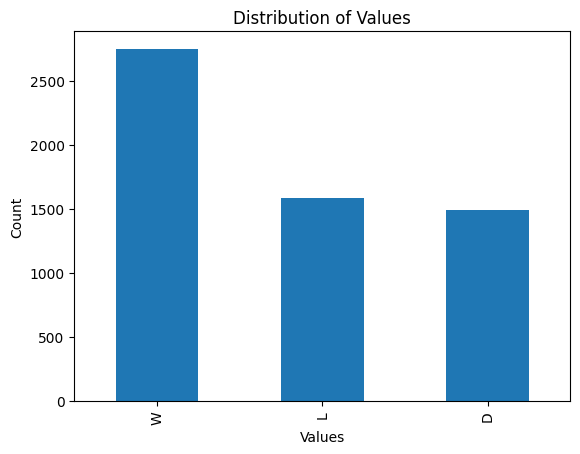

In [14]:
import matplotlib.pyplot as plt

value_counts.plot(kind = 'bar')
plt.xlabel('Values')
plt.ylabel('Count')
plt.title('Distribution of Values')
plt.show()

In [15]:
# Find non-numeric columns
non_numeric_cols = df.select_dtypes(include=['object']).columns
print(non_numeric_cols)


Index([], dtype='object')


In [16]:
df.columns

Index(['B365H', 'B365D', 'B365A', 'overall_rating_home', 'overall_rating_away',
       'overall_rating_difference', 'min_overall_rating_home',
       'min_overall_rating_away', 'max_overall_rating_home',
       'max_overall_rating_away',
       ...
       'SUM(away_matches.std_overall_rating_away)_AWAY',
       'SUM(away_matches.std_overall_rating_home)_AWAY',
       'NUM_UNIQUE(home_matches.DAY(date))_AWAY',
       'NUM_UNIQUE(home_matches.MONTH(date))_AWAY',
       'NUM_UNIQUE(home_matches.WEEKDAY(date))_AWAY',
       'NUM_UNIQUE(home_matches.YEAR(date))_AWAY',
       'NUM_UNIQUE(away_matches.DAY(date))_AWAY',
       'NUM_UNIQUE(away_matches.MONTH(date))_AWAY',
       'NUM_UNIQUE(away_matches.WEEKDAY(date))_AWAY',
       'NUM_UNIQUE(away_matches.YEAR(date))_AWAY'],
      dtype='object', length=453)

In [17]:
# Use one-hot encoding to convert non-numeric columns
df = pd.get_dummies(df, columns=non_numeric_cols)


In [18]:
#visualizations and data analysis
print(df.head())
print(df.info())
print(df.describe())
print(df.head())


   B365H  B365D  B365A  overall_rating_home  overall_rating_away  \
0   1.91   3.40    4.0                746.0                783.0   
1   1.36   4.75    8.5                772.0                790.0   
2   1.40   4.33    8.5                733.0                770.0   
3   1.80   3.50    4.5                809.0                778.0   
4   1.55   3.75    6.5                763.0                791.0   

   overall_rating_difference  min_overall_rating_home  \
0                      -37.0                     60.0   
1                      -18.0                     58.0   
2                      -37.0                     60.0   
3                       31.0                     64.0   
4                      -28.0                     60.0   

   min_overall_rating_away  max_overall_rating_home  max_overall_rating_away  \
0                     63.0                     77.0                     92.0   
1                     63.0                     92.0                     92.0   
2       

In [19]:
# Check for null values
print(df.isnull().sum())


B365H                                          0
B365D                                          0
B365A                                          0
overall_rating_home                            0
overall_rating_away                            0
                                              ..
NUM_UNIQUE(home_matches.YEAR(date))_AWAY       0
NUM_UNIQUE(away_matches.DAY(date))_AWAY        0
NUM_UNIQUE(away_matches.MONTH(date))_AWAY      0
NUM_UNIQUE(away_matches.WEEKDAY(date))_AWAY    0
NUM_UNIQUE(away_matches.YEAR(date))_AWAY       0
Length: 453, dtype: int64


             B365H        B365D        B365A  overall_rating_home  \
count  5828.000000  5828.000000  5828.000000          5828.000000   
mean      2.462383     3.541033     4.445932           754.217056   
std       1.685710     1.188921     3.498781            25.496533   
min       0.000000     0.000000     0.000000           646.000000   
25%       1.610000     3.250000     2.400000           738.000000   
50%       2.100000     3.400000     3.500000           754.000000   
75%       2.700000     3.750000     5.250000           771.000000   
max      21.000000    13.000000    34.000000           862.000000   

       overall_rating_away  overall_rating_difference  \
count          5828.000000                5828.000000   
mean            754.233013                  -0.015957   
std              25.156464                  35.045841   
min             662.000000                -138.000000   
25%             738.000000                 -23.000000   
50%             754.000000          

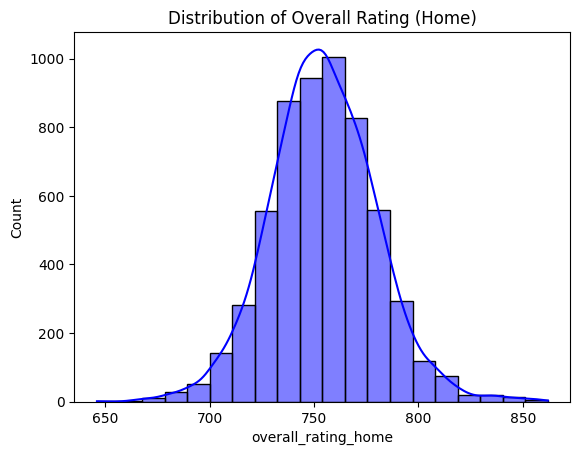

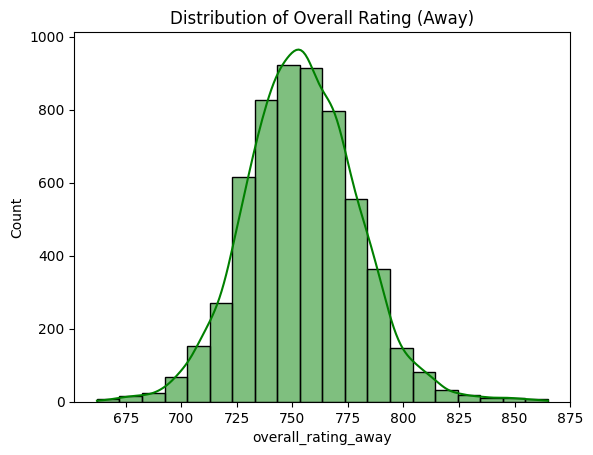

In [20]:
# Basic statistics for numeric columns
print(df.describe())

# Distribution of key columns
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(df['overall_rating_home'], kde=True, bins=20, color='blue')
plt.title('Distribution of Overall Rating (Home)')
plt.show()

sns.histplot(df['overall_rating_away'], kde=True, bins=20, color='green')
plt.title('Distribution of Overall Rating (Away)')
plt.show()


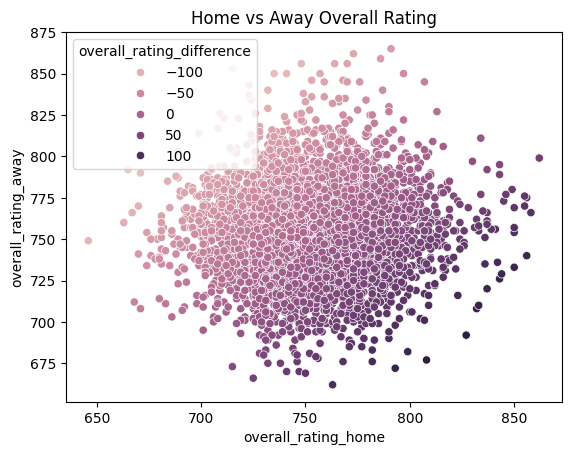

In [21]:
# Scatter plot of overall_rating_home vs overall_rating_away
sns.scatterplot(data=df, x='overall_rating_home', y='overall_rating_away', hue='overall_rating_difference')
plt.title('Home vs Away Overall Rating')
plt.show()

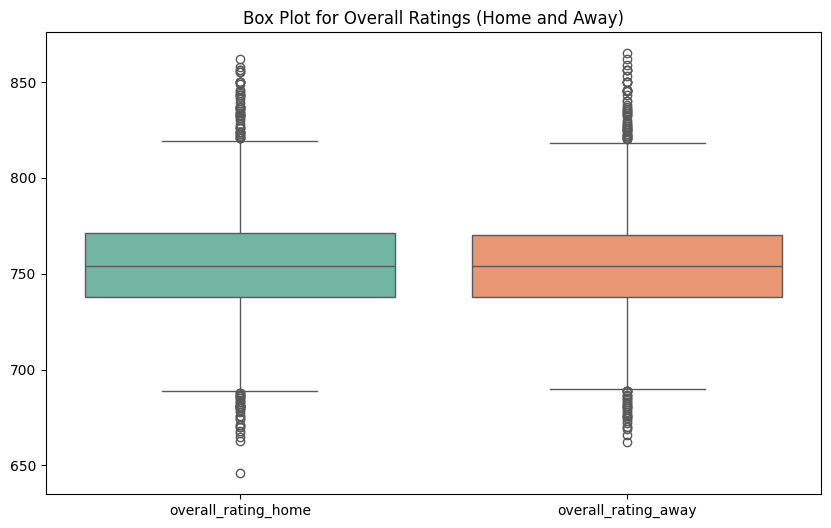

In [22]:
# Box plot for overall ratings
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['overall_rating_home', 'overall_rating_away']], palette='Set2')
plt.title('Box Plot for Overall Ratings (Home and Away)')
plt.show()

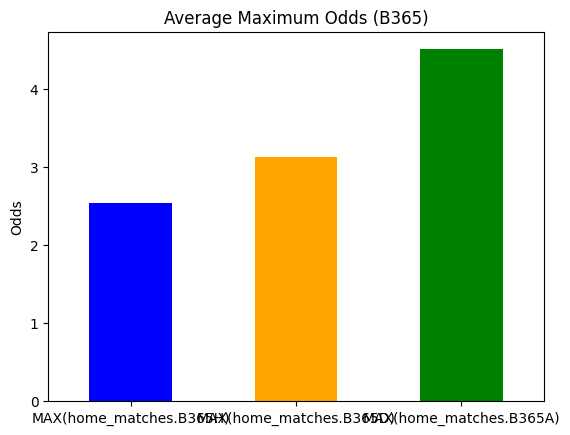

In [23]:
# Bar plot for maximum odds (B365H, B365D, B365A)
b365_odds = df[['MAX(home_matches.B365H)', 'MAX(home_matches.B365D)', 'MAX(home_matches.B365A)']].mean()

b365_odds.plot(kind='bar', color=['blue', 'orange', 'green'])
plt.title('Average Maximum Odds (B365)')
plt.ylabel('Odds')
plt.xticks(rotation=0)
plt.show()


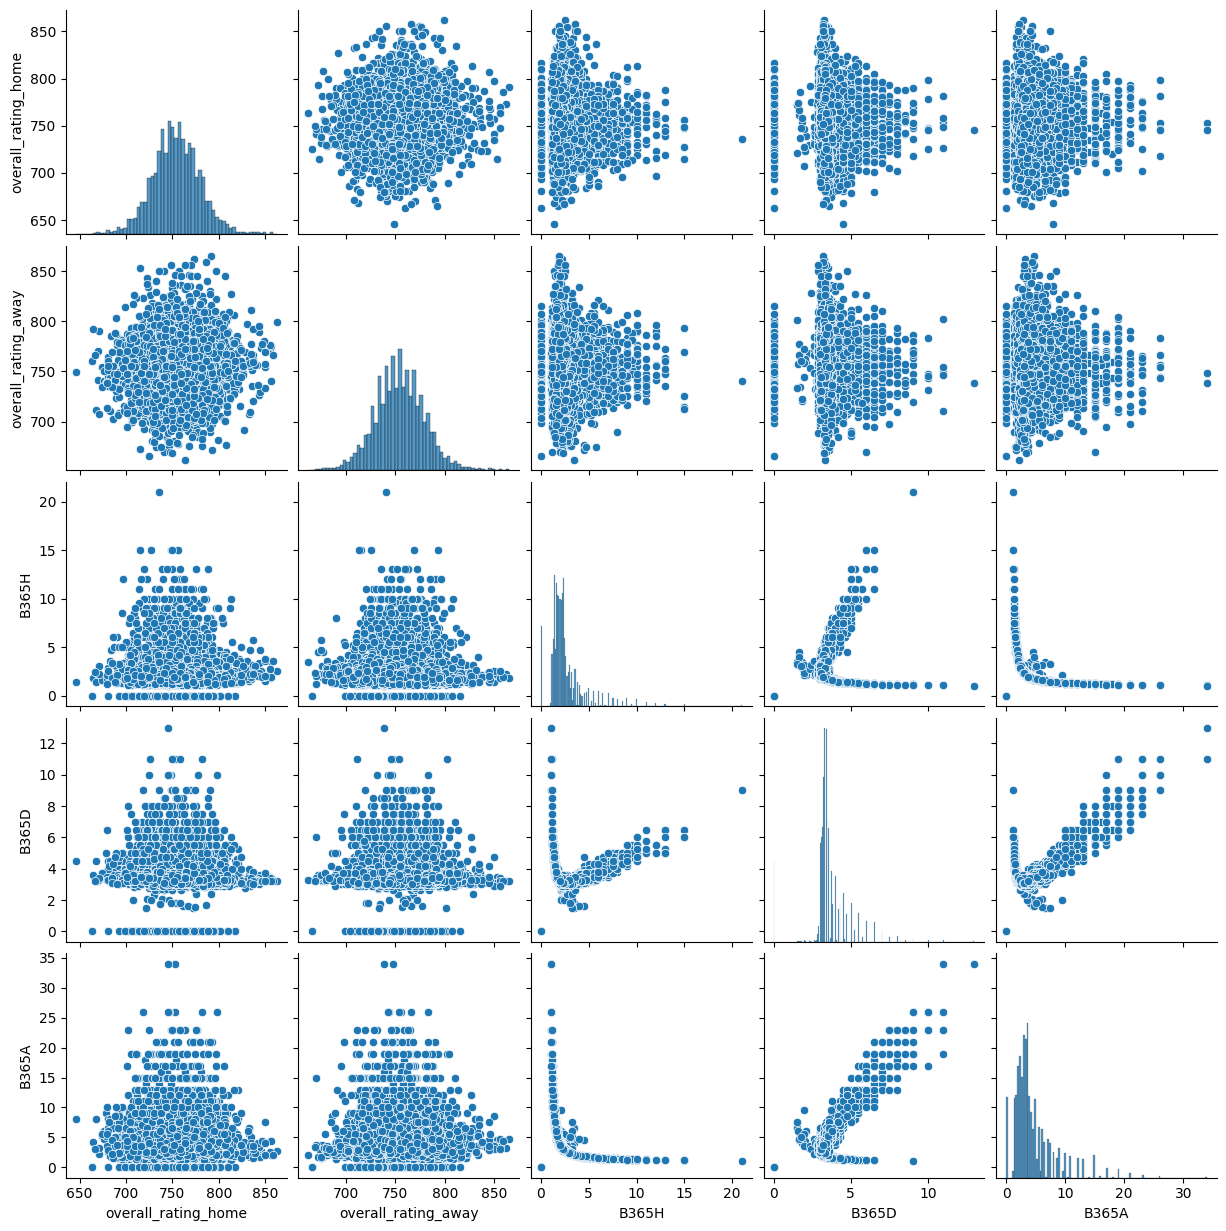

In [24]:
# Pairplot for selected features
sns.pairplot(df[['overall_rating_home', 'overall_rating_away', 'B365H', 'B365D', 'B365A']])
plt.show()

<ipython-input-25-b5e3b0780e0d>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['overall_rating_home'], shade=True, color='blue', label='Home')
<ipython-input-25-b5e3b0780e0d>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['overall_rating_away'], shade=True, color='red', label='Away')


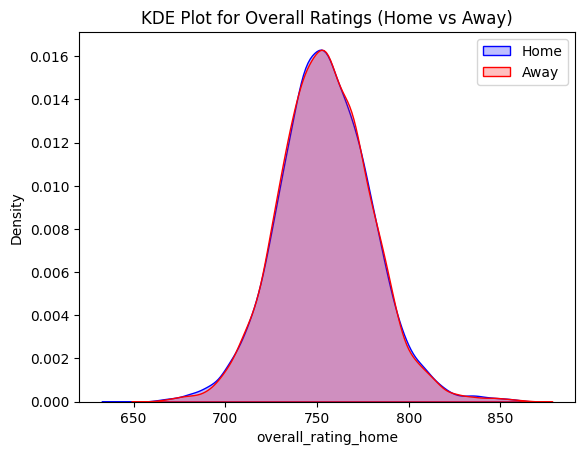

In [25]:
# KDE Plot for overall ratings
sns.kdeplot(df['overall_rating_home'], shade=True, color='blue', label='Home')
sns.kdeplot(df['overall_rating_away'], shade=True, color='red', label='Away')
plt.title('KDE Plot for Overall Ratings (Home vs Away)')
plt.legend()
plt.show()

In [28]:
!pip install xgboost lightgbm catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.0 MB/s eta 0:00:00


In [43]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score # Import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import numpy as np
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size = 0.2, shuffle=True, random_state=42)

# Select only numeric columns
X_train = X_train.select_dtypes(include=['number'])
X_test = X_test.select_dtypes(include=['number'])

# Standardize the numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the label encoder
label_encoder = LabelEncoder()

# Encode the target variable
# This is the crucial step to fix the error.
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# ================================
# Model Training and Evaluation with AUC-ROC
# ================================

# Define models to train
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'Support Vector Machine': SVC(probability=True, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Neural Network': MLPClassifier(max_iter=1000),
    'Extra Trees': ExtraTreesClassifier(class_weight='balanced'),
    'XGBoost': XGBClassifier(eval_metric='mlogloss'),
    # 'LightGBM': LGBMClassifier(force_col_wise=True),
    'CatBoost': CatBoostClassifier(verbose=0)
}

# Train and evaluate models using cross-validation
print("\nTraining and evaluating models...")
results = {}
roc_data = {}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Function to train and evaluate models, including AUC-ROC computation
from sklearn.metrics import roc_curve, auc
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt

def train_and_evaluate_model_with_auc(model_name, model, X_train, y_train, X_test, y_test, skf):
    """
    Train a model, evaluate it using cross-validation, compute accuracy and AUC-ROC,
    and return evaluation metrics along with ROC curve data.

    Parameters:
    - model_name: Name of the model (string).
    - model: The model instance to be trained and evaluated.
    - X_train, y_train: Training dataset.
    - X_test, y_test: Testing dataset.
    - skf: StratifiedKFold cross-validator instance.

    Returns:
    - Dictionary containing metrics and ROC data for the model.
    """
    try:
        # Cross-validation scores
        cv_scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy')

        # Train the model
        model.fit(X_train, y_train)

        # Predictions
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test) if hasattr(model, "predict_proba") else model.decision_function(X_test)

        # Compute metrics
        acc = accuracy_score(y_test, y_pred)
        fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1], pos_label=1) if y_prob.ndim > 1 else roc_curve(y_test, y_prob, pos_label=1)
        auc_score = auc(fpr, tpr)

        print(f"Model: {model_name}")
        print(f"Accuracy: {acc:.4f}")
        print(f"AUC-ROC: {auc_score:.4f}")

        return {
            "model_name": model_name,
            "accuracy": acc,
            "auc": auc_score,
            "cv_scores": cv_scores,
            "fpr": fpr,
            "tpr": tpr
        }
    except Exception as e:
        print(f"Error in training and evaluating model {model_name}: {e}")
        return None



Training and evaluating models...


In [44]:
# Evaluate all models
for model_name, model in models.items():
    print(f"\nEvaluating {model_name}...")
    result = train_and_evaluate_model_with_auc(
        model_name, model, X_train_scaled, y_train, X_test_scaled, y_test, skf
    )
    if result:
        results[model_name] = result

# Visualize or analyze results
print("\nEvaluation Summary:")
for model_name, metrics in results.items():
    print(f"{model_name}: Accuracy = {metrics['accuracy']:.4f}, AUC-ROC = {metrics['auc']:.4f}")


Evaluating Logistic Regression...
Model: Logistic Regression
Accuracy: 0.4305
AUC-ROC: 0.6589

Evaluating Support Vector Machine...
Model: Support Vector Machine
Accuracy: 0.4280
AUC-ROC: 0.6546

Evaluating Random Forest...
Model: Random Forest
Accuracy: 0.4966
AUC-ROC: 0.6611

Evaluating Gradient Boosting...
Model: Gradient Boosting
Accuracy: 0.4940
AUC-ROC: 0.6619

Evaluating K-Nearest Neighbors...
Model: K-Nearest Neighbors
Accuracy: 0.4194
AUC-ROC: 0.5708

Evaluating Neural Network...
Model: Neural Network
Accuracy: 0.4460
AUC-ROC: 0.6294

Evaluating Extra Trees...
Model: Extra Trees
Accuracy: 0.4846
AUC-ROC: 0.6490

Evaluating XGBoost...
Model: XGBoost
Accuracy: 0.4846
AUC-ROC: 0.6540

Evaluating CatBoost...
Model: CatBoost
Accuracy: 0.4923
AUC-ROC: 0.6615

Evaluation Summary:
Logistic Regression: Accuracy = 0.4305, AUC-ROC = 0.6589
Support Vector Machine: Accuracy = 0.4280, AUC-ROC = 0.6546
Random Forest: Accuracy = 0.4966, AUC-ROC = 0.6611
Gradient Boosting: Accuracy = 0.4940, 

In [33]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Initialize the label encoder
label_encoder = LabelEncoder()

# Encode the target labels
y = label_encoder.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size = 0.2, shuffle=True, random_state=42)

# Select only numeric columns
X_train = X_train.select_dtypes(include=['number'])
X_test = X_test.select_dtypes(include=['number'])

# Standardize the numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# Initialize the model
model = Sequential()

# Input layer and first hidden layer
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))

model.add(Dense(64, activation = 'relu'))
# Additional hidden layer
model.add(Dense(32, activation='relu'))

# Output layer for multiclass classification with 3 classes
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [35]:
# Train the model
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_data=(X_test_scaled, y_test))


Epoch 1/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4698 - loss: 1.0542 - val_accuracy: 0.4794 - val_loss: 1.0492
Epoch 2/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5191 - loss: 0.9745 - val_accuracy: 0.4734 - val_loss: 1.0438
Epoch 3/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5591 - loss: 0.9182 - val_accuracy: 0.4777 - val_loss: 1.0659
Epoch 4/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5904 - loss: 0.8764 - val_accuracy: 0.4820 - val_loss: 1.0666
Epoch 5/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6288 - loss: 0.8178 - val_accuracy: 0.4743 - val_loss: 1.1018
Epoch 6/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6611 - loss: 0.7608 - val_accuracy: 0.4425 - val_loss: 1.1503
Epoch 7/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6947 - loss: 0.7107 - val_accuracy: 0.4726 - val_loss: 1.2007
Epoch 8/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7247 - loss: 0.6489 - val_accuracy: 0.

In [39]:
#with pca
# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Define models
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Neural Network": MLPClassifier(random_state=42, max_iter=300),
    "Logistic Regression": LogisticRegression(max_iter=200, random_state=42),
    "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
    "SVM": SVC(probability=True, random_state=42),
    "k-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Gaussian Naive Bayes": GaussianNB(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42)
}

# Evaluate each model
for name, model in models.items():
    print(f"\nEvaluating {name}...")

    # Train the model
    model.fit(X_train_pca, y_train)

    # Make predictions
    y_pred = model.predict(X_test_pca)
    y_prob = model.predict_proba(X_test_pca) if hasattr(model, "predict_proba") else None

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    if y_prob is not None:
        roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
    else:
        roc_auc = "N/A"
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Print results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC Score: {roc_auc if roc_auc != 'N/A' else 'Not applicable (no predict_proba)'}")
    print(f"Confusion Matrix:\n{conf_matrix}")



Evaluating Random Forest...
Accuracy: 0.4811
ROC AUC Score: 0.5937213162799301
Confusion Matrix:
[[ 14  41 257]
 [ 13  75 243]
 [ 11  40 472]]

Evaluating Gradient Boosting...
Accuracy: 0.4657
ROC AUC Score: 0.6090955358655341
Confusion Matrix:
[[ 11  63 238]
 [ 17  99 215]
 [ 25  65 433]]

Evaluating Neural Network...


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.3945
ROC AUC Score: 0.543955429936683
Confusion Matrix:
[[ 83  76 153]
 [ 93  93 145]
 [130 109 284]]

Evaluating Logistic Regression...
Accuracy: 0.4803
ROC AUC Score: 0.6221039558701257
Confusion Matrix:
[[ 24  56 232]
 [ 23 108 200]
 [ 24  71 428]]

Evaluating Linear Discriminant Analysis...
Accuracy: 0.4777
ROC AUC Score: 0.6216421676561631
Confusion Matrix:
[[ 23  56 233]
 [ 26  99 206]
 [ 28  60 435]]

Evaluating SVM...
Accuracy: 0.4803
ROC AUC Score: 0.5862335496706558
Confusion Matrix:
[[  5  44 263]
 [  5  83 243]
 [  4  47 472]]

Evaluating k-Nearest Neighbors...
Accuracy: 0.4177
ROC AUC Score: 0.552662673945718
Confusion Matrix:
[[105  72 135]
 [ 97  97 137]
 [138 100 285]]

Evaluating Gaussian Naive Bayes...
Accuracy: 0.4228
ROC AUC Score: 0.5903936375308065
Confusion Matrix:
[[ 92  52 168]
 [112  89 130]
 [142  69 312]]

Evaluating XGBoost...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [00:45:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.4520
ROC AUC Score: 0.5930755537460357
Confusion Matrix:
[[ 27  71 214]
 [ 43 102 186]
 [ 49  76 398]]

Evaluating LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29835
[LightGBM] [Info] Number of data points in the train set: 4662, number of used features: 117
[LightGBM] [Info] Start training from score -1.374778
[LightGBM] [Info] Start training from score -1.311512
[LightGBM] [Info] Start training from score -0.738789
Accuracy: 0.4854
ROC AUC Score: 0.6056617101296631
Confusion Matrix:
[[ 31  72 209]
 [ 30 112 189]
 [ 35  65 423]]

Evaluating CatBoost...
Accuracy: 0.4580
ROC AUC Score: 0.5997520572925795
Confusion Matrix:
[[ 23  70 219]
 [ 37 104 190]
 [ 41  75 407]]


In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Initialize the model
model = Sequential()

# Input layer with batch normalization
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(BatchNormalization())
model.add(Dropout(0.3))  # Dropout to prevent overfitting

# Hidden layers
model.add(Dense(64, activation='relu', kernel_regularizer='l2'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(32, activation='relu', kernel_regularizer='l2'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Output layer for multiclass classification with 3 classes
model.add(Dense(3, activation='softmax'))

# Compile the model with a learning rate scheduler
optimizer = Adam(learning_rate=0.001)  # Start with a smaller learning rate
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# Train the model
history = model.fit(
    X_train_scaled, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[lr_scheduler],
    verbose=2
)
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
117/117 - 8s - 66ms/step - accuracy: 0.3888 - loss: 2.5955 - val_accuracy: 0.4577 - val_loss: 2.1971 - learning_rate: 0.0010
Epoch 2/50
117/117 - 0s - 4ms/step - accuracy: 0.4658 - loss: 2.1903 - val_accuracy: 0.4759 - val_loss: 2.0058 - learning_rate: 0.0010
Epoch 3/50
117/117 - 0s - 4ms/step - accuracy: 0.4621 - loss: 1.9812 - val_accuracy: 0.4909 - val_loss: 1.8377 - learning_rate: 0.0010
Epoch 4/50
117/117 - 1s - 5ms/step - accuracy: 0.4929 - loss: 1.7736 - val_accuracy: 0.4984 - val_loss: 1.6920 - learning_rate: 0.0010
Epoch 5/50
117/117 - 1s - 5ms/step - accuracy: 0.4899 - loss: 1.6213 - val_accuracy: 0.4973 - val_loss: 1.5563 - learning_rate: 0.0010
Epoch 6/50
117/117 - 0s - 4ms/step - accuracy: 0.5173 - loss: 1.4767 - val_accuracy: 0.5027 - val_loss: 1.4538 - learning_rate: 0.0010
Epoch 7/50
117/117 - 0s - 4ms/step - accuracy: 0.5111 - loss: 1.3730 - val_accuracy: 0.5070 - val_loss: 1.3708 - learning_rate: 0.0010
Epoch 8/50
117/117 - 0s - 4ms/step - accuracy: 0.5253 